## Labwork 4 | Point localization.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot(*shapes,
         size=6,
         lim=15,
         major=5,
         with_points=True,
         point_size=5,
         close=True,
         from_origin=False,
         show_legend=False,
         **common_plot_kw):
    fig, ax = plt.subplots(figsize=(size, size))

    for item in shapes:
        if isinstance(item, tuple):
            shape, plot_kw = item
        else:
            shape, plot_kw = item, {}

        shape = np.asarray(shape)
        x = shape[:, 0] / shape[:, 2]
        y = shape[:, 1] / shape[:, 2]

        if close:
            xx = np.append(x, x[0])
            yy = np.append(y, y[0])
        else:
            xx, yy = x, y

        if "label" in plot_kw:
            show_legend = True

        ax.plot(xx, yy, **({"linewidth": 1.6} | common_plot_kw | plot_kw))

        if with_points:
            ax.scatter(x, y, s=point_size, zorder=3)

    ax.set_aspect("equal")

    if from_origin:
        ax.set_xlim(0, lim)
        ax.set_ylim(0, lim)
        major_ticks = np.arange(0, lim + 1, major)
        minor_ticks = np.arange(0, lim + 1, 1)
    else:
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        major_ticks = np.arange(-lim, lim + 1, major)
        minor_ticks = np.arange(-lim, lim + 1, 1)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which="major", linestyle="-", linewidth=0.8)
    ax.grid(which="minor", linestyle=":", linewidth=0.5)

    if show_legend:
        ax.legend()

    plt.show()




### Task 1

Задайте отрезки $s_1, s_2, s_3, ..., s_{10}$ (должно быть не менее двух пар пересекающихся отрезков среди заданных).

Найдите пересекающиеся отрезки:
- параметризацией прямых, содержащих отрезки (найдите точки пересечения);
- методом косых произведений;
- методом заметающей прямой (алгоритмом Бентли-Оттмана).

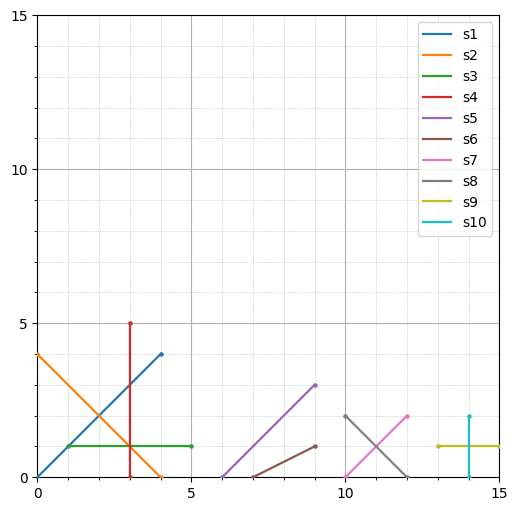

In [ ]:
segments = [
  [np.array([0, 0, 1]), np.array([4, 4, 1])],
  [np.array([0, 4, 1]), np.array([4, 0, 1])],
  [np.array([1, 1, 1]), np.array([5, 1, 1])],
  [np.array([3, 0, 1]), np.array([3, 5, 1])],
  [np.array([6, 0, 1]), np.array([9, 3, 1])],
  [np.array([7, 0, 1]), np.array([9, 1, 1])],
  [np.array([10, 0, 1]), np.array([12, 2, 1])],
  [np.array([10, 2, 1]), np.array([12, 0, 1])],
  [np.array([13, 1, 1]), np.array([15, 1, 1])],
  [np.array([14, 0, 1]), np.array([14, 2, 1])]
]

plot(*[(np.array(seg), {"label": f"s{i+1}"}) for i, seg in enumerate(segments)],
     from_origin=True, close=False, show_legend=True)

In [21]:
from itertools import combinations

def to_cartesian(p):
    return p[:2] / p[2]

def param_intersect(seg1, seg2):
    A, B = map(to_cartesian, seg1)
    C, D = map(to_cartesian, seg2)
    u = B - A
    v = D - C
    denom = u[0] * v[1] - u[1] * v[0]
    if abs(denom) < 1e-10:
        return None  # parallel or colinear
    AC = C - A
    t = (AC[0] * v[1] - AC[1] * v[0]) / denom
    s = (AC[0] * u[1] - AC[1] * u[0]) / denom
    if 0 <= t <= 1 and 0 <= s <= 1:
        return A + t * u  # intersection point
    return None

def ccw(A, B, C):
    return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

def cross_intersect(seg1, seg2):
    A, B = map(to_cartesian, seg1)
    C, D = map(to_cartesian, seg2)
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

param_results = []
cross_results = []

for i, j in combinations(range(len(segments)), 2):
    p = param_intersect(segments[i], segments[j])
    cross = cross_intersect(segments[i], segments[j])
    if p is not None:
        param_results.append(((i + 1, j + 1), p))
    if cross:
        cross_results.append((i + 1, j + 1))

param_results, cross_results

([((1, 2), array([2., 2.])),
  ((1, 3), array([1., 1.])),
  ((1, 4), array([3., 3.])),
  ((2, 3), array([3., 1.])),
  ((2, 4), array([3., 1.])),
  ((3, 4), array([3., 1.])),
  ((7, 8), array([11.,  1.])),
  ((9, 10), array([14.,  1.]))],
 [(1, 2), (1, 4), (2, 3), (2, 4), (3, 4), (7, 8), (9, 10)])

In [23]:
def bentley_ottmann_fixed(segments):
    events = []
    for i, (p1, p2) in enumerate(segments):
        a, b = sorted([to_cartesian(p1), to_cartesian(p2)], key=lambda p: p[0])
        events.append(Event(a[0], i, True, a))
        events.append(Event(b[0], i, False, b))

    events.sort()
    active = []
    intersections = set()

    def neighbors(i):
        return (active[i - 1] if i > 0 else None,
                active[i + 1] if i < len(active) - 1 else None)

    def check_and_add(a_idx, b_idx):
        if a_idx is None or b_idx is None:
            return
        if cross_intersect(segments[a_idx], segments[b_idx]):
            intersections.add(tuple(sorted((a_idx + 1, b_idx + 1))))

    for event in events:
        idx = event.seg_idx
        seg = segments[idx]
        x = event.x

        if event.is_left:
            y = get_y_at_x(seg, x)
            position = bisect_left(active, idx, key=lambda i: get_y_at_x(segments[i], x))
            active.insert(position, idx)
            check_and_add(active[position - 1] if position > 0 else None, idx)
            check_and_add(idx, active[position + 1] if position + 1 < len(active) else None)
        else:
            try:
                position = active.index(idx)
                pred = active[position - 1] if position > 0 else None
                succ = active[position + 1] if position + 1 < len(active) else None
                active.pop(position)
                if pred is not None and succ is not None:
                    check_and_add(pred, succ)
            except ValueError:
                pass  # segment already removed, can occur in degenerate configs

    return sorted(intersections)

bentley_ottmann_results = bentley_ottmann_fixed(segments)
bentley_ottmann_results


[(1, 2), (2, 3), (2, 4), (7, 8), (9, 10)]

### Task 2

Задайте простой 𝑛-угольник координатами его вершин $P_1, P_2, ..., P_n (n \geq 7)$ и точки $M_1, M_2, ..., M_k  (k \geq 5)$.

Определите положение точек $M_1, M_2, ..., M_k$ относительно n-угольника:
- угловым методом;
- лучевым методом.

In [ ]:
# Вершины 9-угольника (например, правильный)
n = 9
theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
polygon = [(10 + 8 * np.cos(t), 10 + 8 * np.sin(t)) for t in theta]

# 5 случайных точек
test_points = [(12, 10), (5, 5), (18, 10), (10, 10), (14, 14)]


In [ ]:
import numpy as np

def angle_sum_method(polygon, point):
    total_angle = 0
    px, py = point
    n = len(polygon)

    for i in range(n):
        x1, y1 = polygon[i][0] - px, polygon[i][1] - py
        x2, y2 = polygon[(i + 1) % n][0] - px, polygon[(i + 1) % n][1] - py

        # Векторное и скалярное произведения
        dot = x1 * x2 + y1 * y2
        cross = x1 * y2 - x2 * y1

        angle = np.arctan2(cross, dot)
        total_angle += angle

    return abs(round(total_angle / (2 * np.pi))) == 1  # True if inside


In [ ]:
def ray_casting_method(polygon, point):
    x, y = point
    n = len(polygon)
    inside = False

    for i in range(n):
        x0, y0 = polygon[i]
        x1, y1 = polygon[(i + 1) % n]

        if ((y0 > y) != (y1 > y)):
            x_intersect = (x1 - x0) * (y - y0) / (y1 - y0 + 1e-12) + x0
            if x < x_intersect:
                inside = not inside

    return inside
